<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/NegEx_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install stanza
!pip install spacy_stanza
!pip install negspacy
!pip install negex
!pip install negfinder
!pip install negexpander
!pip install spacy-pipeline-negex



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 35.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for negspacy: filename=negspacy-1.0.4-py3-none-any.whl size=12535 sha256=5013b2aa2df1a829fa95ae70fd5d0a210476a4770227f0f3ad5eb5c018b6b5c9
  Stored in directory: /root/.cache/pip/wheels/15/31/f0/3a217aaedf320e4df653347cd6538f3648263b864c8e140853
Successfully built negspacy
ERROR: Could not find a version that satisfies the requirement negfinder (from versions: none)
ERROR: No matching distribution found for negfinder
ERROR: Could not find a version that satisfies the requirement negexpander (from versions: none)
ERROR: No matching distribution found for negexpander
ERROR: Could not find a version that satisfies the requirement spacy-pipe

In [4]:
import spacy # to build a nlp pipeline
import stanza # for named entity recognition
# this package wraps Stanza around Spacy, so that we can use Stanza in a spaCy pipeline.
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset # to customize negation terms
import pandas as pd
from tqdm.auto import tqdm
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

## **RBM #1 : NegEx**

In [6]:
# download and initialize a mimic pipeline with an i2b2 NER model
# stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = spacy_stanza.load_pipeline('en', package='mimic', processors={'ner': 'i2b2'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| ner       | i2b2    |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [10]:
# nlp.add_pipe("negex", config={"ent_types":["PROBLEM","TEST",'TREATMENT']})

ValueError: ignored

In [12]:
# nlp = spacy.load("en_core_sci_sm")
# import spacy
# from spacy.pipeline.negex import NegexComponent

# nlp = spacy.load("en_core_sci_sm")
# negex = NegexComponent(config={"chunk_prefix": ["no", "none", "not", "nor", "without"]})
# nlp.add_pipe(negex)


In [13]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model with the NegEx component
# nlp = spacy.load("en_core_sci_sm")
nlp.add_pipe("negex", config={"chunk_prefix": ["no", "none", "not", "nor", "without","lack"]})

# Initialize an empty list to store predictions
predictions = []

# Iterate through the text in your DataFrame
for text in tqdm(df["doc_text_original"]):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether the sentence contains negations
    contains_negation = False

    # Iterate through sentences and check for negations
    for sent in doc.sents:
        for ent in sent.ents:
            if ent._.negex:
                contains_negation = True
                break

    # Determine the final classification (0 for negation, 1 for non-negation)
    prediction = 0 if contains_negation else 1
    predictions.append(prediction)

# Add the predictions as a new column in the dataframe
df['predicted'] = predictions


ValueError: ignored

In [ ]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## **RBM #2 : Filter with negation terms**

In [14]:
import spacy
import pandas as pd

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the negation terms
negation_terms = ["no", "none", "not", "nor", "without"]

# Your DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv("your_dataset.csv")

# Define a function for negation detection
def detect_negation(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether negation is detected
    negation_detected = False

    # Iterate through the tokens and check for negation terms
    for token in doc:
        if token.text.lower() in negation_terms:
            negation_detected = True
            break

    return negation_detected

# Apply the negation detection function to each text in the DataFrame
df["predicted"] = df["doc_text_original"].apply(detect_negation)

# Map the negation detection result to 0 (negation) or 1 (non-negation)
df["predicted"] = df["predicted"].astype(int)



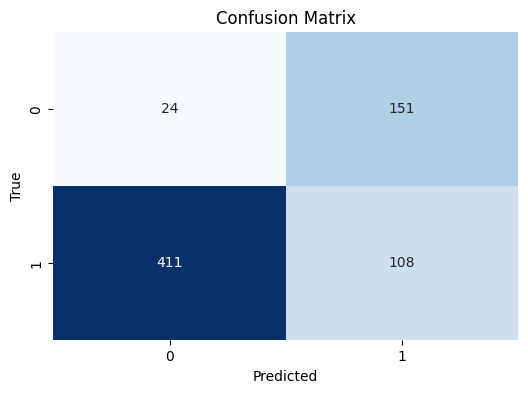

Accuracy: 0.19
Precision: 0.42
Recall: 0.21
F1 Score: 0.28


In [15]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## **RBM #3 : Deterministic Option**

In [38]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

In [34]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize  # Import sent_tokenize from nltk

# Define the topics
topics = ["overpressure", "sand production","oil show"]

# Initialize a dictionary to store selected sentences for each row
selected_sentences = {}

# Iterate through each row of the DataFrame
for index, row in df.iterrows():

    # Convert the text to lowercase
    text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Initialize a list to store selected sentences for this row
    row_selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains any of the specified topics
        if any(topic in sentence for topic in topics):
            row_selected_sentences.append(sentence)

    # Join the selected sentences into a single string
    selected_sentence = ' '.join(row_selected_sentences)

    # Store the selected sentences for this row in the dictionary
    selected_sentences[index] = selected_sentence

# Add the selected_sentences as a new column named 'selected_sentence' next to 'doc_text_original'
df.insert(df.columns.get_loc('doc_text_original') + 1, 'selected_sentence', df.index.map(selected_sentences))

# Define the negation terms
negation_terms = r'\b(?:no|none|not|nor|without)\b'

# Initialize an empty list to store labels for the selected sentences
selected_sentence_labels = []

# Iterate through the 'selected_sentence' column
for sentence, label in zip(df['selected_sentence'], df['label']):
    # Initialize a label for the sentence
    encoded_label = 1 if label.lower() == 'yes' else 0

    # Append the encoded label
    selected_sentence_labels.append(encoded_label)

# Update the 'label' column with the encoded values
df['predicted'] = selected_sentence_labels

df.columns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['id', 'result_id', 'source_name', 'source_type', 'name', 'basin',
       'field_name', 'operator', 'longitude_decimal_degree',
       'longitude_degree', 'longitude_minutes', 'longitude_seconds',
       'longitude_direction', 'latitude_decimal_degree', 'latitude_degree',
       'latitude_minutes', 'latitude_seconds', 'latitude_direction', 'spud',
       'end_of_drill', 'northing', 'easting', 'kelly_bushing', 'well_type',
       'crs', 'derric_floor_elevation', 'rotary_table', 'total_depth', 'tvd',
       'tvdss', 'water_depth', 'play_segment', 'post_drill_conclusion',
       'tagged_wells_count', 'country', 'article_title', 'document_id',
       'document_title', 'page_number', 'dataset', 'label', 'label_code',
       'predicted', 'doc_text_original', 'selected_sentence'],
      dtype='object')

In [35]:
# Add the selected_sentence_labels list as a new column named 'label' next to 'selected_sentence'
# df.insert(df.columns.get_loc('selected_sentence') + 1, 'label_encoded', selected_sentence_labels)
# df["predicted"] = selected_sentence_labels

# Print the DataFrame with the 'label' column
df[['doc_text_original','selected_sentence','label_code','predicted']]

,doc_text_original,selected_sentence,label_code,predicted
0,The Statfjord reservoir is overpressured (emw ...,The Statfjord reservoir is overpressured (emw ...,1,1
1,‘ The Brent reservoir is overpressured (emw 1...,‘ The Brent reservoir is overpressured (emw 1...,1,1
2,"» Finally, the core measurements have not been...",This would somewhat reduce the porosity values...,1,1
3,Also if the pressure in the Lower Unit should ...,Also if the pressure in the Lower Unit should ...,1,1
4,As regards the two pressures obtained in the w...,Most probably they are affected by superchargi...,1,1
...,...,...,...,...
689,21 21A 22 22A 23 23A 24 24A 25 25A 26 26A 27 2...,"Wide, ft, dull, yelwh t/t 20% patchy grny/yell...",1,1
690,"""used to calculate the geochemical Altbough th...",The data in Table 5 indicates Ihat the The two...,1,1
691,"""used to calculate the geochemical Altbough th...",The data in Table 5 indicates Ihat the The two...,1,1
692,lower levels of these unknown compounds is not...,results suggest that the sample represents an ...,1,1


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['label_code'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['predicted'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['label_code'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['predicted'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_4, *[[['label_code', 'predicted']]], **{})
chart

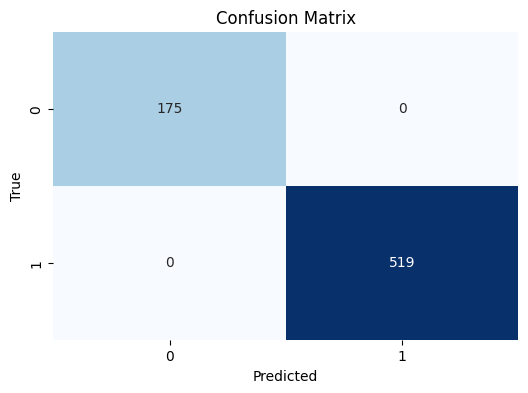

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [36]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
clinical_note = "Patient resting in bed. Patient given azithromycin without any difficulty. Patient has audible wheezing, \
states chest tightness. No evidence of hypertension.\
Patient denies nausea at this time. zofran declined. Patient is also having intermittent sweating associated with pneumonia. \
Patient refused pain but tylenol still given. Neither substance abuse nor alcohol use however cocaine once used in the last year. Alcoholism unlikely.\
Patient has headache and fever. Patient is not diabetic. \
No signs of diarrhea. Lab reports confirm lymphocytopenia. Cardaic rhythm is Sinus bradycardia. \
Patient also has a history of cardiac injury. No kidney injury reported. No abnormal rashes or ulcers. \
Patient might not have liver disease. Confirmed absence of hemoptysis. Although patient has severe pneumonia and fever \
, test reports are negative for COVID-19 infection. COVID-19 viral infection absent."

In [ ]:
# Lemmatizing the notes to capture all forms of negation (e.g., deny: denies, denying)
def lemmatize(note, nlp):
    doc = nlp(note)
    lemNote = [wd.lemma_ for wd in doc]
    return " ".join(lemNote)

# Assuming you have a clinical note text stored in 'clinical_note'
# clinical_note = "Your clinical note text goes here."

# Create a spaCy language model (nlp0) for lemmatization
nlp0 = spacy.load("en_core_sci_sm")

# Lemmatize the clinical note
lem_clinical_note = lemmatize(clinical_note, nlp0)

# Creating a doc object using the BC5CDR model (nlp1)
nlp0 = spacy.load("en_core_sci_sm")
doc = nlp0(lem_clinical_note)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_sm' (0.4.0) was trained with spaCy v3.0.1 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  


In [ ]:
#function to modify options for displacy NER visualization
def get_entity_options():
    entities = ["DISEASE", "CHEMICAL", "NEG_ENTITY"]
    colors = {'DISEASE': 'linear-gradient(180deg, #66ffcc, #abf763)', 'CHEMICAL': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)', "NEG_ENTITY":'linear-gradient(90deg, #ffff66, #ff6600)'}
    options = {"ents": entities, "colors": colors}
    return options
options = get_entity_options()
#visualizing identified Named Entities in clinical input text
displacy.render(doc, style='ent', options=options)

'<div class="entities" style="line-height: 2.5; direction: ltr">your clinical note text go here .</div>'

In [ ]:
import spacy
from negspacy.negex import Negex

# Adding a new pipeline component to identify negation
def neg_model(nlp_model):
    nlp = spacy.load(nlp_model, disable=['parser'])
    nlp.add_pipe('sentencizer')
    negex = Negex(nlp, name="negex", neg_termset=None, ent_types=None, extension_name=None, chunk_prefix=["no", "none", "not", "nor", "without"])
    nlp.add_pipe(negex, last=True)  # Add the 'negex' component last in the pipeline
    return nlp

# Function for handling negation
def negation_handling(nlp_model, note, neg_model):
    results = []
    nlp = neg_model(nlp_model)
    note = note.split(".")  # Sentence tokenizing based on delimiter
    note = [n.strip() for n in note]  # Removing extra spaces at the beginning and end of sentences
    for t in note:
        doc = nlp(t)
        for e in doc.ents:
            rs = str(e._.negex)
            if rs == "True":
                results.append(e.text)
    return results

# List of negative concepts from clinical note identified by negspacy
results0 = negation_handling("en_core_sci_sm", lem_clinical_note, neg_model)


ModuleNotFoundError: ignored

In [ ]:
#function to identify span objects of matched megative phrases from clinical note
def match(nlp,terms,label):
        patterns = [nlp.make_doc(text) for text in terms]
        matcher = PhraseMatcher(nlp.vocab)
        matcher.add(label, None, *patterns)
        return matcher
#replacing the labels for identified negative entities
def overwrite_ent_lbl(matcher, doc):
    matches = matcher(doc)
    seen_tokens = set()
    new_entities = []
    entities = doc.ents
    for match_id, start, end in matches:
        if start not in seen_tokens and end - 1 not in seen_tokens:
            new_entities.append(Span(doc, start, end, label=match_id))
            entities = [
                e for e in entities if not (e.start < end and e.end > start)
            ]
            seen_tokens.update(range(start, end))
doc.ents = tuple(entities) + tuple(new_entities)
    return doc
matcher = match(nlp1, results0,"NEG_ENTITY")
#doc0: new doc object with added "NEG_ENTITY label"
doc0 = overwrite_ent_lbl(matcher,doc)
#visualizing identified Named Entities in clinical input text
displacy.render(doc0, style='ent', options=options)

In [ ]:
#function to add custom negation terms to the existing model
def neg_model2(nlp_model):
    nlp = spacy.load(nlp_model, disable = ['parser'])
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    negex = Negex(nlp)

    negex.preceding_patterns += [nlp('deny'), nlp('refuse'), nlp('neither'), nlp('nor')]
    negex.following_patterns += [nlp('absent'), nlp('deny'), nlp('decline')]
    preceding_update  = [i.text for i in negex.preceding_patterns]
    following_update = [i.text for i in negex.following_patterns]

    negex = Negex(nlp, preceding_negations = preceding_update, following_negations= following_update)
    nlp.add_pipe(negex)
    return nlp
#updated list of all the negative concepts from clinical note identified by negspacy
results1 = negation_handling("en_ner_bc5cdr_md", lem_clinical_note, neg_model2)
matcher = match(nlp1, results1,"NEG_ENTITY")
#doc1: new doc object with added custom concepts for "NEG_ENTITY label"
doc1 = overwrite_ent_lbl(matcher,doc)
#visualizing identified Named Entities in clinical input text
displacy.render(doc, style='ent', options=options)

In [37]:
# Save the updated dataframe to a new CSV file
df.to_csv("your_updated_dataset.csv", index=False)